## Fitting Attempt

In [46]:
''' importing packages '''
import numpy as np 
from scipy.optimize import curve_fit
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

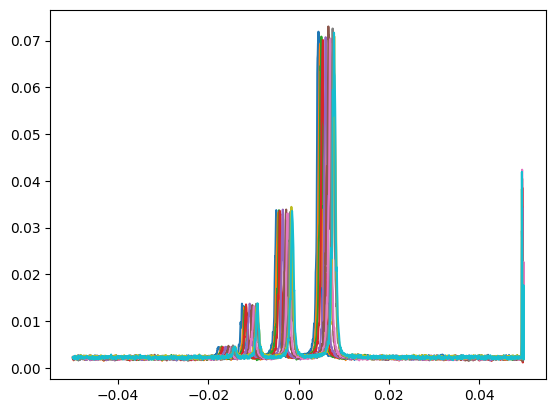

In [47]:
''' importing data '''

# Location and folder names
data_loc = 'D:/151025/'
noQWPoff = 'NoQWP_Mod_off/'
noQWPon = 'NoQWP_Mod_on/'
QWPoff = 'QWP_Mod_off/'
QWPon = 'QWP_Mod_on/'

# use glob to get all the csv files in the folder
path = data_loc + noQWPon
csv_files = glob.glob(os.path.join(path, "*.csv"))
numb_files = len(csv_files) # The number of files

# Make empty list to pupulate data frames with
df = [None]*numb_files

''' This might need to change for different csv files'''
# Make np array to fit all of data in, seconds vs volts
secs = np.zeros((2000, numb_files)) # no of data points vs no of files
volts = np.zeros((2000, numb_files)) # no of data points vs no of files

''' checking data is stored in correct way '''

# loop over the list of csv files and extract data
# Importing docs with pandas - sample
for i in range(numb_files):
    
    df = pd.read_csv(csv_files[i])
    np_df = df.to_numpy() # convert to np array
    secs[:,i], volts[:,i] = np.array(np_df[1:,0]).astype(float), np.array(np_df[1:,1]).astype(float)
    # first column = 'time', second column = voltage

    plt.plot(secs[:,i], volts[:,i])

(400, 10)


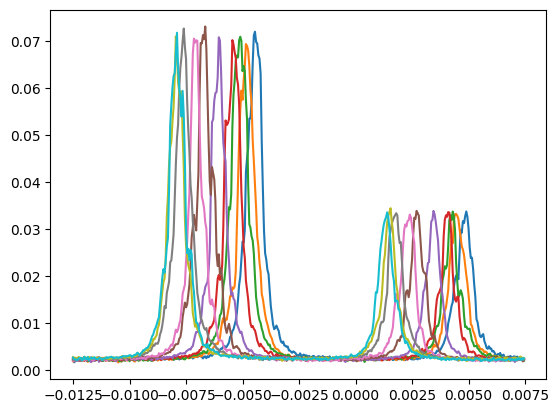

In [48]:
''' Chop data to see Rb lines of interest '''

# flip x axis so spectra is the right way around
secs = np.flip(secs)

start = 850
stop = 1250

# Chop data to see F=3 and F=4 peaks
secsC = secs[start:stop,:]
voltsC = volts[start:stop,:]

plt.plot(secsC,voltsC)
print(np.shape(secsC))

File 0. [ 51 238]
Corresponding x values [ 0.0049  -0.00445]
File 1. [ 60 246]
Corresponding x values [ 0.00445 -0.00485]
File 2. [ 63 251]
Corresponding x values [ 0.0043 -0.0051]
File 3. [ 67 258]
Corresponding x values [ 0.0041  -0.00545]
File 4. [ 80 270]
Corresponding x values [ 0.00345 -0.00605]
File 5. [ 95 282]
Corresponding x values [ 0.0027  -0.00665]
File 6. [101 292]
Corresponding x values [ 0.0024  -0.00715]
File 7. [113 301]
Corresponding x values [ 0.0018 -0.0076]
File 8. [118 308]
Corresponding x values [ 0.00155 -0.00795]
File 9. [121 307]
Corresponding x values [ 0.0014 -0.0079]


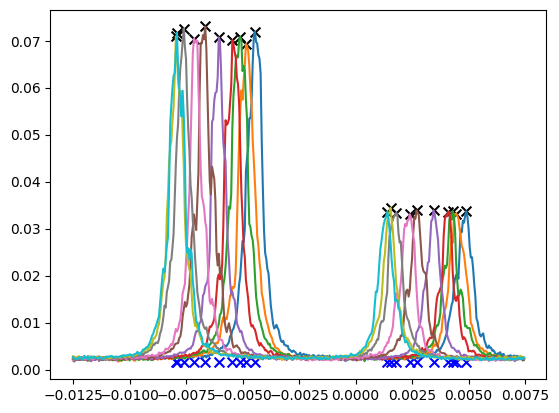

In [49]:
'''Find peaks to determine the x axis scale'''

peaks = [] # empty list for peak positions
secs_peaks = np.zeros((numb_files,2)) # empty list for x axis peak values

for j in range(numb_files):

    # height - to get the two peaks we need
    # distance - to make sure a single peak only is found for each maxima
    # prominence = to make sure noise in sharp gradients is not deceted as peaks
    p, properties = find_peaks(voltsC[:,j], height = 0.03 , distance = 5, prominence = 0.02)
    peaks.append(p)

    # Where on the x axis do the peaks occur? store in secs_peaks
    secs_peaks[j,0] = secsC[p[0],j]
    secs_peaks[j,1] = secsC[p[1],j]

    print('File {}. {}'.format(j,p))
    print('Corresponding x values {}'.format(secs_peaks[j,:]))
    #print(properties)

    plt.plot(secsC[:,j],voltsC[:,j])

    for i in p:
        plt.scatter(secsC[i,j], voltsC[i,j], s = 50, marker = 'x', c = 'k')
    
    for i in secs_peaks[j,:]:
        plt.scatter(i, 0.0015, s = 50, marker = 'x', c = 'b')

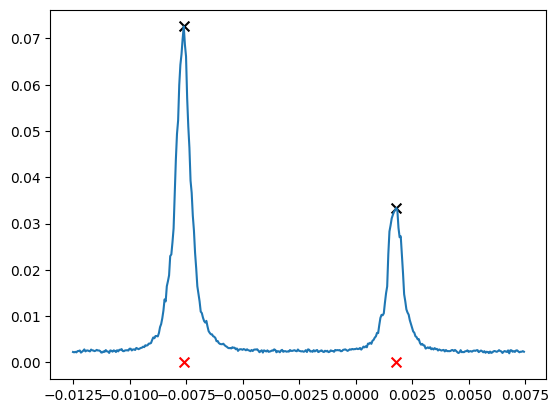

In [50]:
''' To look at each data set and check peaks '''

foi = 7 # file of interest

plt.plot(secsC[:,foi],voltsC[:,foi])

for i in peaks[foi]:
    plt.scatter(secsC[i,foi], voltsC[i,foi], s = 50, marker = 'x', c = 'k')

for i in secs_peaks[foi]:
    plt.scatter(i,0, s=50, marker='x', c='r')

In [51]:
''' re-scale x axis comparing to frequency spacing between peaks '''

# https://www.researchgate.net/publication/258290104_Multi-photon_effects_of_transmittance_spectra_for_closed_and_open_ladder-type_atomic_configurations/figures?lo=1
# Good paper / diagram of hyperfine energy splitting in Rb 87

deltaf = 14.6 # MHz
deltaf_err = 0.1 # MHz

# Make list into array - 
# wont work if finding peaks function is finding incorrect (extra) peaks
peaks = np.array(peaks)

# difference between peaks found with find_peaks - arb units
diff_arr = np.abs(secs_peaks[:,1] - secs_peaks[:,0])

print(diff_arr)

# Take the mean and std
diff_mean, diff_stderr = np.mean(diff_arr), (np.std(diff_arr) / np.sqrt(np.size(diff_arr)))
                                           
print('The mean spacing between the peaks is {} p/m {} in arb units'.format(diff_mean, diff_stderr))

[0.00935 0.0093  0.0094  0.00955 0.0095  0.00935 0.00955 0.0094  0.0095
 0.0093 ]
The mean spacing between the peaks is 0.00942 p/m 2.932575659723025e-05 in arb units


In [52]:
# Divide freqency spacing (MhZ) by spacing on x axis (arb) to get scale factor in MHz

sf = deltaf / diff_mean

print('The scale factor between axes is {} MHz'.format(sf))

print(sf*secsC / 10**6) #edit

The scale factor between axes is 1549.8938428874735 MHz
[[ 1.15467091e-05  1.15467091e-05  1.15467091e-05 ...  1.15467091e-05
   1.15467091e-05  1.15467091e-05]
 [ 1.14692144e-05  1.14692144e-05  1.14692144e-05 ...  1.14692144e-05
   1.14692144e-05  1.14692144e-05]
 [ 1.13917197e-05  1.13917197e-05  1.13917197e-05 ...  1.13917197e-05
   1.13917197e-05  1.13917197e-05]
 ...
 [-1.92186837e-05 -1.92186837e-05 -1.92186837e-05 ... -1.92186837e-05
  -1.92186837e-05 -1.92186837e-05]
 [-1.92961783e-05 -1.92961783e-05 -1.92961783e-05 ... -1.92961783e-05
  -1.92961783e-05 -1.92961783e-05]
 [-1.93736730e-05 -1.93736730e-05 -1.93736730e-05 ... -1.93736730e-05
  -1.93736730e-05 -1.93736730e-05]]


In [53]:
''' Aside - error function '''

def div(a,b):
    return a / b

n1 = 6
n2 = 3
n1_err = 0.1
n2_err = 0.1

ans = div(n1,n2)

alpha1 = np.abs(div(n1 + n1_err,n2) - div(n1,n2))
alpha2 = np.abs(div(n1,n2 + n2_err) - div(n1,n2))

print(alpha1,alpha2)

alpha_tot = np.sqrt(alpha1**2 + alpha2**2)

print(ans,'p/m', alpha_tot)

0.033333333333333215 0.06451612903225823
2.0 p/m 0.07261846883829276


In [55]:
def error_calc(f, variables: np.array, errs: np.array):
    return 1